In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time

0.0019829273223876953
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.08 0.4  0.32 0.   0.   0.   0.  ]
 [0.   0.   0.08 0.92 1.   1.   0.52 0.   0.   0.  ]
 [0.   0.   0.4  1.   1.   1.   0.8  0.   0.   0.  ]
 [0.   0.   0.24 1.   1.   1.   0.72 0.   0.   0.  ]
 [0.   0.   0.   0.36 0.8  0.72 0.12 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


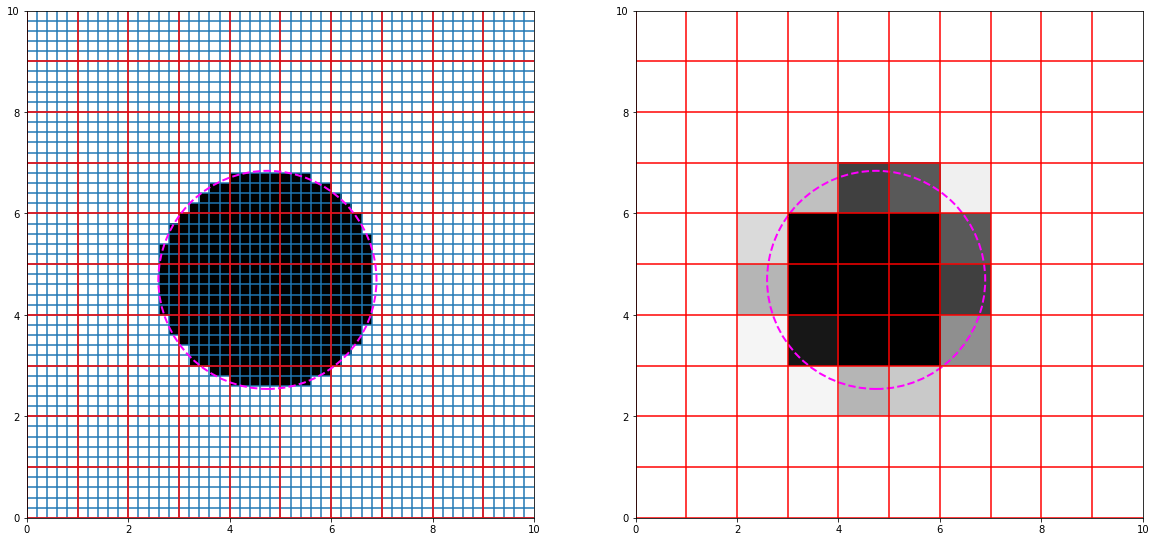

In [26]:
data = np.ones((5,10,10))

data_shape = data.shape
size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]

start = time.time()
Y,X = np.ogrid[0:size_y,0:size_x]

core_diameter_pixels = 4.3
core_radius_pixels = core_diameter_pixels/2
#np.random.seed(0)
core_x_pixels = np.random.uniform(low=4.3,high=5.7)
core_y_pixels = np.random.uniform(low=4.3,high=5.7)

weight_map = np.zeros((size_y,size_x)).astype(int)

weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1

rows,cols = np.argwhere(weight_map).T
row_min,row_max = np.min(rows),np.max(rows)+1
col_min,col_max = np.min(cols),np.max(cols)+1


rfactor = 5

# # the refined grid is defined to have a minimum of 100 pixels
# # accross the diameter of the fiber
# rfactor = int(100/core_diameter_pixels)
# # if the diameter exceeds 100 pixels already, 
# # use the original regular grid
# if rfactor<1:
#     rfactor = 1
rsize_x,rsize_y = (col_max-col_min)*rfactor,(row_max-row_min)*rfactor
Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
maskr = np.zeros((rsize_y,rsize_x))


maskr[np.sqrt((Xr+col_min*rfactor+0.5 - core_x_pixels*rfactor)**2 +
              (Yr+row_min*rfactor+0.5 - core_y_pixels*rfactor)**2) < core_radius_pixels*rfactor ]=1

weight_mapr = np.zeros((size_y*rfactor,size_x*rfactor))
weight_mapr[row_min*rfactor:row_max*rfactor,col_min*rfactor:col_max*rfactor] = maskr

patch = maskr.reshape(row_max-row_min,rfactor,col_max-col_min,rfactor).sum(axis=(1,3)).astype(float)/rfactor**2

weight_map = weight_map.astype(float)
weight_map[row_min:row_max,col_min:col_max]=patch

core_array = np.sum(data * weight_map.reshape(1,size_y,size_x),axis=(1,2)),np.pi*core_radius_pixels**2

print(time.time()-start)


fig,axarr = plt.subplots(1,2,figsize=(20,10))

ax = axarr.flat[0]
ax.imshow(weight_mapr,cmap='Greys',origin='lower',extent=(0,size_x,0,size_y))

core = Circle(xy=(core_x_pixels,core_y_pixels),radius=core_diameter_pixels/2,
              transform=ax.transData,edgecolor='magenta',facecolor='None',linestyle='dashed',linewidth=2,zorder=9)

for i in range(size_x*rfactor):
    ax.axvline(i/rfactor)
    ax.axhline(i/rfactor)
    
for i in range(size_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')
    
ax.add_artist(core)

ax = axarr.flat[1]
ax.imshow(weight_map,cmap='Greys',origin='lower',extent=(0,size_x,0,size_y),vmin=0,vmax=1)

for i in range(size_x):
    ax.axvline(i,color='red')
    ax.axhline(i,color='red')

core = Circle(xy=(core_x_pixels,core_y_pixels),radius=core_diameter_pixels/2,
              transform=ax.transData,edgecolor='magenta',facecolor='None',linewidth=2,linestyle='dashed')

ax.add_artist(core)
print(weight_map)

In [6]:
data = np.ones((1000,512,512))
core_diameter_pixels = 4.3
core_x_pixels = np.random.uniform(low=4.3,high=5.7)
core_y_pixels = np.random.uniform(low=4.3,high=5.7)

def Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels):
    '''`data` must be in format (Nels,spatial_yels,spatial_xels).Nels denotes 
    the number of wavelength/velocity elements. Consequently, data[0] should 
    return a slice of the cube with dimensions (spatial_yels, spatial_xels).'''
    
    data_shape = data.shape
    size_y, size_x, Nels = data_shape[1],data_shape[2],data_shape[0]
    core_radius_pixels = core_diameter_pixels/2
    
    Y,X = np.ogrid[0:size_y,0:size_x]
    # initialize weight map
    weight_map = np.zeros((size_y,size_x)).astype(int)
    # select rectangular region around fiber
    weight_map[(np.abs(X+0.5-core_x_pixels)<core_radius_pixels+0.5) * 
               (np.abs(Y+0.5-core_y_pixels)<core_radius_pixels+0.5)] = 1
    
    rows,cols = np.argwhere(weight_map).T
    row_min,row_max = np.min(rows),np.max(rows)+1
    col_min,col_max = np.min(cols),np.max(cols)+1
    
    
    # the refined grid is defined to have a minimum of 100 pixels
    # accross the diameter of the fiber
    rfactor = int(100/core_diameter_pixels)
    # if the diameter exceeds 100 pixels already, 
    # use the original regular grid
    if rfactor<1:
        rfactor = 1

    rsize_x,rsize_y = (col_max-col_min)*rfactor,(row_max-row_min)*rfactor
    Yr,Xr = np.ogrid[0:rsize_y,0:rsize_x]
    maskr = np.zeros((rsize_y,rsize_x))


    maskr[np.sqrt((Xr+col_min*rfactor+0.5 - core_x_pixels*rfactor)**2 +
                  (Yr+row_min*rfactor+0.5 - core_y_pixels*rfactor)**2) < core_radius_pixels*rfactor ]=1

    weight_mapr = np.zeros((size_y*rfactor,size_x*rfactor))
    weight_mapr[row_min*rfactor:row_max*rfactor,col_min*rfactor:col_max*rfactor] = maskr

    patch = maskr.reshape(row_max-row_min,rfactor,col_max-col_min,rfactor).sum(axis=(1,3)).astype(float)/rfactor**2

    weight_map = weight_map.astype(float)
    weight_map[row_min:row_max,col_min:col_max]=patch
    
    return(np.sum(data*weight_map.reshape(1,size_y,size_x),axis=(1,2)))


start = time.time()
core_array = Fiber_Observe(data,core_x_pixels,core_y_pixels,core_diameter_pixels)

print(time.time()-start)
size_x = data.shape[2]
size_y = data.shape[1]






(1000,)
9.09390902519226


In [6]:
np.im2col

AttributeError: module 'numpy' has no attribute 'im2col'